In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

from tqdm import tqdm

from sklearn.externals import joblib

In [2]:
import re
from nltk import tokenize, TweetTokenizer
from pymystem3 import Mystem

In [3]:
from gensim.models import KeyedVectors

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, \
                        coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

In [5]:
DATA_DIR = Path('../data/')
DATASET_DIR = DATA_DIR.joinpath('dataset/')
FASTTEXT_DIR = DATA_DIR.joinpath('embeddings/')

In [6]:
df_random = pd.read_csv(DATASET_DIR.joinpath('rusentiment_random_posts.csv'))
df_preselected = pd.read_csv(DATASET_DIR.joinpath('rusentiment_preselected_posts.csv'))
df_test = pd.read_csv(DATASET_DIR.joinpath('rusentiment_test.csv'))

In [7]:
df_train = pd.concat([df_random, df_preselected], ignore_index=True)

In [12]:
df_train.head()

,label,text
0,negative,"А попа подозревала давно,что ты с кавказа..пер..."
1,speech,З прошедшим Днем Ангела))))))))
2,skip,Два дня до отлёта с острова!!!!!!!
3,negative,"Блин, почему эта жизнь столь не справедлива (((("
4,skip,где еще встречать свой день рождения как не на...


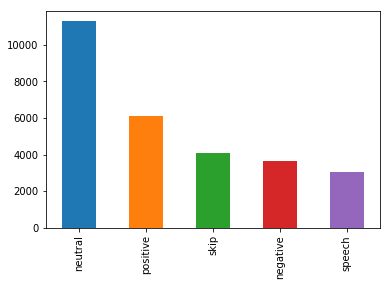

In [50]:
df_train.label.value_counts().plot(kind='bar')

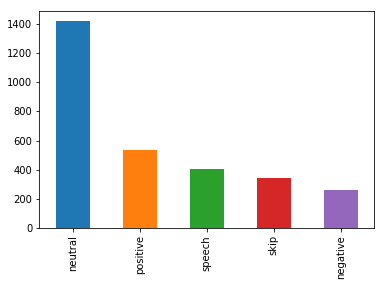

In [51]:
df_test.label.value_counts().plot(kind='bar')

In [52]:
vec_file = str(FASTTEXT_DIR.joinpath('fasttext.min_count_100.vk_posts_all_443550246.300d.vec'))
vec_file

'../data/embeddings/fasttext.min_count_100.vk_posts_all_443550246.300d.vec'

In [53]:
embeddings = KeyedVectors.load_word2vec_format(vec_file)

In [54]:
def tokenize_only(text):
    tokenizer = TweetTokenizer()
    text = re.sub(r'#', '# ', text)
    tokens = tokenizer.tokenize(text)
    return tokens

In [55]:
def get_embeddings_of_error_token(token, tokens_embeddings, embeddings):
    tokens = tokenize.WordPunctTokenizer().tokenize(token)
    for t in tokens:
        try:
            tokens_embeddings.append(embeddings.get_vector(t))
        except KeyError:
            pass
    return tokens_embeddings

In [56]:
def create_data_matrix_embeddings(samples, embeddings):
    embeddings_dim = embeddings.vector_size
    nb_samples = len(samples)
    X = np.zeros((nb_samples, embeddings_dim), dtype=np.float32)

    nb_empty = 0
    empty_samples = []
    for i, tokens in tqdm(enumerate(samples)):
        tokens_embeddings = []
        for t in tokens:
            try:
                tokens_embeddings.append(embeddings.get_vector(t))
            except KeyError:
                tokens_embedding = get_embeddings_of_error_token(t, tokens_embeddings, embeddings)

        if len(tokens_embeddings) > 0:
            mean_embeddings = np.mean(tokens_embeddings, axis=0)
            X[i] = mean_embeddings
        else:
            nb_empty += 1
            empty_samples.append(i)

    print(f'Empty samples: {nb_empty}')

    return X, empty_samples

In [57]:
def score_model(model, X, y_true, labels):
    y_pred = model.predict(X)

    if len(set(y_true)) == 2:
        average = 'binary'
        pos_label = int(np.argwhere(labels != 'rest'))
    else:
        average = 'weighted'
        pos_label = 1

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average, pos_label=pos_label)
    precision = precision_score(y_true, y_pred, average=average, pos_label=pos_label)
    recall = recall_score(y_true, y_pred, average=average, pos_label=pos_label)

    return accuracy, f1, precision, recall

In [58]:
samples_train = []
for message in tqdm(df_train.text):
    samples_train.append(tokenize_only(message))
    
labels_train = df_train.label.values

samples_test = []
for message in tqdm(df_test.text):
    samples_test.append(tokenize_only(message))
    
labels_test = df_test.label.values

100%|██████████| 2967/2967 [00:00<00:00, 20931.52it/s]


In [59]:
X_train, empty_samples_train = create_data_matrix_embeddings(samples_train, embeddings)

28218it [00:01, 14562.72it/s]

Empty samples: 112


In [60]:
X_test, empty_samples_test = create_data_matrix_embeddings(samples_test, embeddings)

2967it [00:00, 14062.54it/s]

Empty samples: 11


In [61]:
for ind in empty_samples_train:
    print(df_train.text[ind], '-', df_train.label[ind])

БлондинкоОО - neutral
ХВАТИТЗАЛИВАТЬ - negative
ААЗЗАЗАЗХАЗАХААЗЗАА - skip
уахахахаххахаааахахаха - positive
вытаюююююю - skip
порсмотри димьян - neutral
паагморарпапаппапапрпрппнаепаепапапщимашившсшоапщиагмсомагмврсоосовеплпарпарспааналепаггарыцрпнакпенуершквнрвгрщшвунппщгеннкепенеершкншкгеннеегекенеекшнашардзоагрпшпакнршоаершппгпепгеаепенеееееепнгпеукеегшрпнрагпощрппгмлрсевлаацлщапоивнирпгагсршивщзпиуршпмугз - skip
Катяяяяяяяяяя - neutral
БЛЯЯЯЯЯНУПОЧЕМУТЫТАКАЯКРАСИВАЯ - skip
либерж кпадону - skip
девачька:) - neutral
рпрпррртоьболпрмас - skip
внатурекупарос - skip
Начинааается :) - skip
минималистика - neutral
Опаааа Ребетняя - skip
Понаприсоединяли - negative
Хаһан быраһынньыктар бүтэллэр - skip
хахахаххаахха - positive
вытыка тишиншила - skip
ДОЛБОЁЁЁЁЁЁЁЁЁЁЁЁЁБ - negative
АХАХХАХХХАХАХ - positive
обсыкалово - negative
игоряяяяян - neutral
залипное зачитание - skip
ЗАААЗДРЮЮЮ - skip
ПОСТИ
ПОСТИ
ПОСТИ - skip
Микроблогинг - neutral
ЛАЛАЛЛАЛАА - skip
СКучашкккиииииииииииииииииии - ne

In [92]:
for ind in empty_samples_test:
    print(df_test.text[ind], '-', df_test.label[ind])

армииииииииииииииииииииииииииииииииииииииииииииииииин - neutral
Находские беспризорники - neutral
Владимировичи - neutral
Роналдооооо - neutral
Кумеееееееееееееееееееее :) - skip
ахахвхвхахахбхахахахбхахахбхахахахахахбхахбха - positive
Мастурбирен порноста - skip
вспомнииииим крутууую - positive
ОПАСА СУЦКА - skip
ИЗМЕНЩИИИИКК - negative
ИюньНасРадует - positive


In [62]:
# Удаляем все нулевые вектора

X_train = np.delete(X_train, empty_samples_train, axis=0)
labels_train = np.delete(labels_train, empty_samples_train)

X_test = np.delete(X_test, empty_samples_test, axis=0)
labels_test = np.delete(labels_test, empty_samples_test)

In [132]:
# # Все нулевые вектора будут иметь лейбл skip

# for ind in empty_samples:
#     labels_train[ind] = 'skip'
    
# for ind in empty_samples_test:
#     labels_test[ind] = 'skip'

In [64]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_train)
print(f'Labels: {label_encoder.classes_}')

y_train = label_encoder.transform(labels_train)
y_test = label_encoder.transform(labels_test)

Labels: ['negative' 'neutral' 'positive' 'skip' 'speech']


In [74]:
# save label_encoder
joblib.dump(label_encoder, str(DATA_DIR.joinpath('label_encoder.pkl')))

['../data/label_encoder.pkl']

In [66]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
X_train.shape

(28106, 300)

In [38]:
# save scaler
joblib.dump(scaler, str(DATA_DIR.joinpath('scaler.pkl')))

['../data/scaler.pkl']

In [96]:
model_svc = SVC()
model_svc.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [97]:
score_model(model, X_train, y_train, label_encoder.classes_)

(0.6919342263803246,
 0.6796367714216114,
 0.7014865501131173,
 0.6919342263803246)

In [98]:
score_model(model, X_test, y_test, label_encoder.classes_)

(0.6976744186046512,
 0.6887124797119177,
 0.6940595534907658,
 0.6976744186046512)

In [164]:
#  Удалили все нулевые вектора

models = [
    LogisticRegression(),
    LinearSVC(),
    GradientBoostingClassifier(),
    # net,
]
results = []
for model in models:
    model.fit(X_train, y_train)  # , sample_weight=sample_weight

    result = score_model(model, X_train, y_train, label_encoder.classes_)
    results.append(result)

print('===== RESULTS =====')
for model, (accuracy_train, f1_train, precision_train, recall_train) in zip(models, results):
    model_name = model.__class__.__name__
    print(f'{model_name}: F1 train {f1_train:.3f}')

    
results_test = []
for model in models:

    result = score_model(model, X_test, y_test, label_encoder.classes_)
    results_test.append(result)

print('===== RESULTS TEST =====')
for model, (accuracy_train, f1_train, precision_train, recall_train) in zip(models, results_test):
    model_name = model.__class__.__name__
    print(f'{model_name}: F1 test {f1_train:.3f}')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


===== RESULTS =====
LogisticRegression: F1 train 0.632
LinearSVC: F1 train 0.627
GradientBoostingClassifier: F1 train 0.681
===== RESULTS TEST =====
LogisticRegression: F1 test 0.694
LinearSVC: F1 test 0.696
GradientBoostingClassifier: F1 test 0.690


In [165]:
model_svc = SVC()
model_svc.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [166]:
score_model(model, X_test, y_test, label_encoder.classes_)

(0.6999323410013532,
 0.6902278650256204,
 0.6981902339361834,
 0.6999323410013532)

In [415]:
from keras import backend as K
from keras.utils import to_categorical
from keras.models import load_model, Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, InputLayer
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.metrics import binary_accuracy
from keras.callbacks import Callback
from keras.optimizers import Adam, SGD

In [416]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta

def f1score(y_true, y_pred):
    return fbeta(y_true, y_pred, beta=1)

In [417]:
input_shape = X_train.shape[1]
input_shape

300

In [39]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform([[i] for i in labels_train])
y_test_mlb = mlb.transform([[i] for i in labels_test])

In [41]:
# save mlb
joblib.dump(mlb, str(DATA_DIR.joinpath('mlb.pkl')))

['../data/mlb.pkl']

In [40]:
label_encoder.classes_

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [448]:
n_classes = mlb.classes_.shape[0]

In [422]:
model = Sequential()
model.add(Dense(input_shape, input_shape=(input_shape,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(n_classes))
model.add(Activation('softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 300)               90300     
_________________________________________________________________
activation_89 (Activation)   (None, 300)               0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               30100     
_________________________________________________________________
activation_90 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 505       
__________

In [423]:
batch_size = 256
epochs = 14

In [424]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0

In [425]:
history = model.fit_generator(generator=nn_batch_generator(X_train, y_train_mlb, batch_size),
                              epochs=epochs,
                              validation_data=(X_test, y_test_mlb),
#                               callbacks=[metrics],
                              steps_per_epoch=X_train.shape[0]/batch_size)

Epoch 1/14
110/109 [==============================] - 5s 49ms/step - loss: 0.3662 - acc: 0.8410 - precision: 0.6651 - recall: 0.3915 - f1score: 0.4907 - val_loss: 0.2748 - val_acc: 0.8814 - val_precision: 0.8310 - val_recall: 0.5105 - val_f1score: 0.6320
Epoch 2/14
110/109 [==============================] - 2s 20ms/step - loss: 0.3101 - acc: 0.8643 - precision: 0.7423 - recall: 0.4872 - f1score: 0.5867 - val_loss: 0.2565 - val_acc: 0.8916 - val_precision: 0.8275 - val_recall: 0.5785 - val_f1score: 0.6807
Epoch 3/14
110/109 [==============================] - 2s 20ms/step - loss: 0.2931 - acc: 0.8716 - precision: 0.7545 - recall: 0.5272 - f1score: 0.6198 - val_loss: 0.2489 - val_acc: 0.8951 - val_precision: 0.8169 - val_recall: 0.6120 - val_f1score: 0.6996
Epoch 4/14
110/109 [==============================] - 2s 20ms/step - loss: 0.2827 - acc: 0.8770 - precision: 0.7654 - recall: 0.5517 - f1score: 0.6402 - val_loss: 0.2477 - val_acc: 0.8960 - val_precision: 0.8129 - val_recall: 0.6228 - 

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1score', 'loss', 'acc', 'precision', 'recall', 'f1score'])


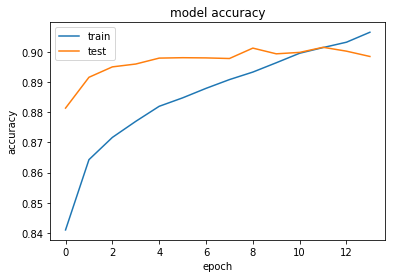

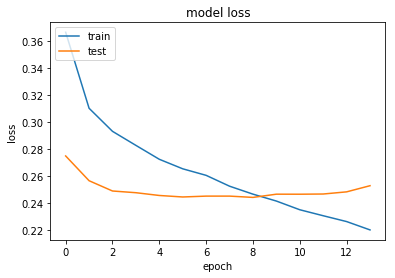

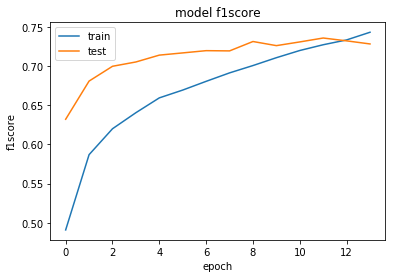

In [426]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1score
plt.plot(history.history['f1score'])
plt.plot(history.history['val_f1score'])
plt.title('model f1score')
plt.ylabel('f1score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [427]:
preds = model.predict(X_test)

In [72]:
X_test.shape

(2956, 300)

In [434]:
y_preds = []
for pred in preds:
    max_pred = max(pred)
    max_pred_position = np.where(pred==max_pred)[0][0]
    y_preds.append(mlb.classes_[max_pred_position])

In [438]:
y_preds_encode = label_encoder.transform(y_preds)

In [441]:
y_true = y_test
y_pred = y_preds_encode

In [442]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', pos_label=1)
precision = precision_score(y_true, y_pred, average='weighted', pos_label=1)
recall = recall_score(y_true, y_pred, average='weighted', pos_label=1)

In [458]:
print('MLP model: \n accuracy - %s, \n f1 - %s, \n precision - %s, \n recall - %s' % (accuracy, f1, precision, recall))

MLP model: 
 accuracy - 0.7449255751014885, 
 f1 - 0.7373051183372504, 
 precision - 0.7392262644920623, 
 recall - 0.7449255751014885


In [444]:
# Model SAVE!
model.save(str(DATA_DIR.joinpath('mlp.h5')))